In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

from get_db_url import get_db_url

# Clustering Anomaly Detection Exercises

## 1

Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.

In [2]:
# Load the grocery customers data
grocery = pd.read_sql('SELECT * FROM grocery_customers', get_db_url('grocery_db'), index_col = 'customer_id')
grocery.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 30.9 KB


In [3]:
grocery.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
# Let's look for anomalies in cold storage foods.
columns = [
    'Milk',
    'Frozen',
    'Delicassen'
]

refrigerated = grocery[columns]

In [5]:
# Splitting data? Who needs it?
scaler = MinMaxScaler()
refrigerated = pd.DataFrame(scaler.fit_transform(refrigerated), columns = refrigerated.columns)
refrigerated.head()

,Milk,Frozen,Delicassen
0,0.130727,0.003106,0.027847
1,0.132824,0.028548,0.036984
2,0.119181,0.039116,0.163559
3,0.015536,0.104842,0.037234
4,0.072914,0.063934,0.108093


In [6]:
# Now let's create the DBSCAN model
db_scan = DBSCAN(eps = 0.1, min_samples = 20)
db_scan.fit(refrigerated)

DBSCAN(eps=0.1, min_samples=20)

In [7]:
# Let's create a column for the cluster labels
grocery['labels'] = db_scan.labels_

/var/folders/45/z3vf0vrn1fz5mzs6sp418wym0000gn/T/ipykernel_1299/2730259329.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, .95, 1])


Text(0.5, 0, 'Grocery')

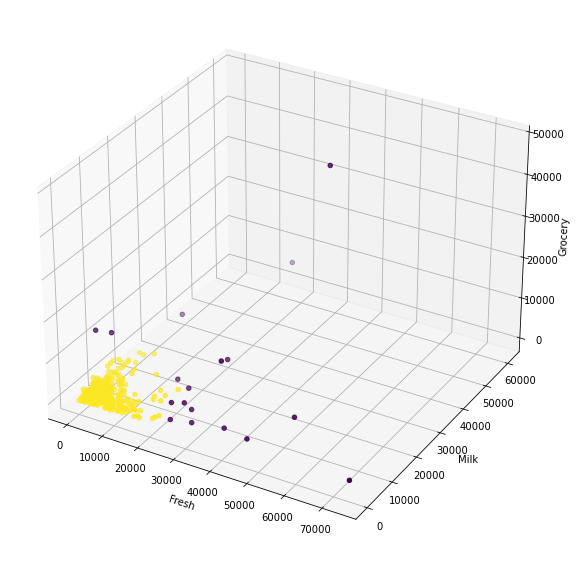

In [8]:
# Now let's plot the results

fig = plt.figure(figsize = (8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1])

ax.scatter(grocery.Milk, grocery.Frozen, grocery.Delicassen, c = grocery.labels)

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

## 2

Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [9]:
# The SQL query we'll use to read the data from the database.
sql = '''
SELECT
    *
FROM logs;
'''

# Download the curriculum logs data from the MySQL database.
logs = pd.read_sql(sql, get_db_url('curriculum_logs'))
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       900223 non-null  object 
 1   time       900223 non-null  object 
 2   path       900222 non-null  object 
 3   user_id    900223 non-null  int64  
 4   cohort_id  847330 non-null  float64
 5   ip         900223 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 41.2+ MB


In [20]:
# Aggregate the data to get the total unique values for date, path, and cohort_id.
id_counts = logs.groupby('user_id')[['date','path','cohort_id']].nunique()
id_counts

,date,path,cohort_id
user_id,,,
1,637,976,2
2,83,151,1
3,107,169,1
4,54,143,1
5,82,197,1
...,...,...,...
977,10,12,1
978,9,18,1
979,9,20,1


In [21]:
# Here we'll scale the data before building the DBSCAN model.
# Splitting data? Yeah right.

scaler = MinMaxScaler()
id_counts_scaled = pd.DataFrame(scaler.fit_transform(id_counts), columns = id_counts.columns)
id_counts_scaled.head()

,date,path,cohort_id
0,0.768116,1.000000,0.666667
1,0.099034,0.153846,0.333333
2,0.128019,0.172308,0.333333
3,0.064010,0.145641,0.333333
4,0.097826,0.201026,0.333333


In [22]:
# Now let's use DBSCAN to find anomolies in the id_counts dataframe.

db_scan = DBSCAN(eps = 0.1, min_samples = 5)
db_scan.fit(id_counts_scaled)

DBSCAN(eps=0.1)

In [23]:
# Assign the labels created by DBSCAN to the id_counts dataframe.
id_counts['labels'] = db_scan.labels_

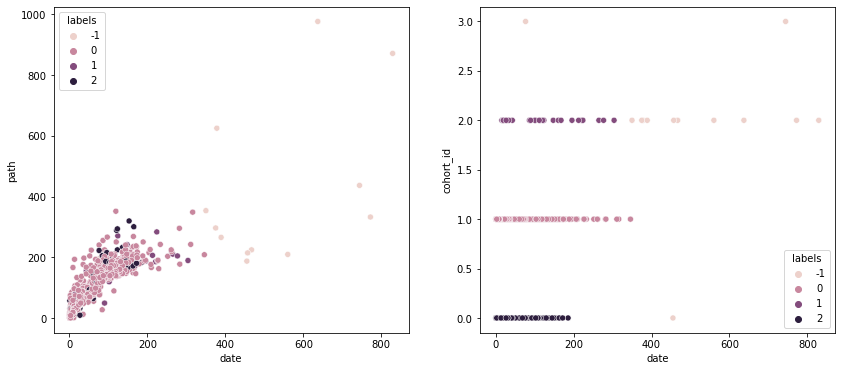

In [24]:
# Now let's see the results.

fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (14, 6))

sns.scatterplot(data = id_counts, x = 'date', y = 'path', hue = 'labels', ax = ax[0])
sns.scatterplot(data = id_counts, x = 'date', y = 'cohort_id', hue = 'labels', ax = ax[1]);

We can see that there are a handful of anomalies. Let's see these specific rows.

In [25]:
id_counts[id_counts.labels == -1]

,date,path,cohort_id,labels
user_id,,,,
1,637,976,2,-1
11,829,871,2,-1
53,772,333,2,-1
64,744,437,3,-1
88,77,197,3,-1
211,560,210,2,-1
248,378,625,2,-1
314,467,225,2,-1
315,457,215,2,-1


These seem to be users that have accessed many different curriculum pages on many different dates for the most part. All but one of these users have been assigned more than 1 cohort. I would want to look into the user that has no cohort id's assigned to them.

## 3

Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [29]:
# We'll use this SQL query to select the Zillow data from the database.
sql = '''
SELECT
    bedroomcnt,
    calculatedfinishedsquarefeet
FROM properties_2017
JOIN propertylandusetype
    ON propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid
    AND (propertylandusetype.propertylandusedesc IN ('Single Family Residential', 'Inferred Single Family Residential'))
JOIN predictions_2017 ON properties_2017.parcelid = predictions_2017.parcelid
AND predictions_2017.transactiondate LIKE '2017%%';
'''

# Download the data from the MySQL database.
zillow = pd.read_sql(sql, get_db_url('zillow'))
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52441 non-null  float64
 1   calculatedfinishedsquarefeet  52359 non-null  float64
dtypes: float64(2)
memory usage: 819.5 KB


In [30]:
# Let's drop all the nulls so we have a clean dataframe.
zillow = zillow.dropna()
zillow.isnull().sum()

bedroomcnt                      0
calculatedfinishedsquarefeet    0
dtype: int64

In [33]:
# Now let's scale the data before creating the DBSCAN model.
# Splitting data is for over-achievers.
scaler = MinMaxScaler()
zillow_scaled = pd.DataFrame(scaler.fit_transform(zillow), columns = zillow.columns)
zillow_scaled.head(2)

,bedroomcnt,calculatedfinishedsquarefeet
0,0.285714,0.136324
1,0.142857,0.061327


In [34]:
# Now let's create and fit the DBSCAN model on our un-split data.
db_scan = DBSCAN(eps = 0.1, min_samples = 20)
db_scan.fit(zillow_scaled)

DBSCAN(eps=0.1, min_samples=20)

In [35]:
# Now we can assign the labels created by DBSCAN to the original dataframe.
zillow['labels'] = db_scan.labels_

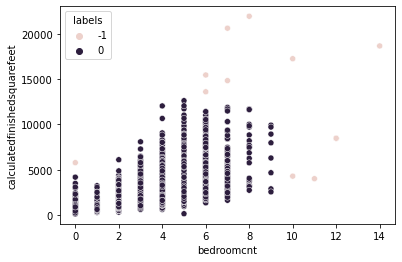

In [36]:
# Finally let's see the results.

sns.scatterplot(data = zillow, x = 'bedroomcnt', y = 'calculatedfinishedsquarefeet', hue = 'labels');

In [37]:
# Let's see the rows that were labeled as anomalies.
zillow[zillow.labels == -1]

,bedroomcnt,calculatedfinishedsquarefeet,labels
590,0.0,5782.0,-1
4864,8.0,21929.0,-1
5740,14.0,18654.0,-1
16571,7.0,20612.0,-1
21981,11.0,4012.0,-1
27017,6.0,13598.0,-1
28105,6.0,15450.0,-1
29557,12.0,8469.0,-1
29558,12.0,8469.0,-1
29559,12.0,8469.0,-1


It looks like the anomalies are homes that are either excessively large or have an excessive amount of bedrooms with one that has 0 bedrooms. I think the 0 bedroom home definitely requires additional investigation.